# Import libraries

In [26]:
import os
import shutil
import json
import itertools
from collections import Counter
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam, AdamW
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from transformers import ViTModel
from transformers import T5ForConditionalGeneration, T5Config
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt
from transformers.modeling_outputs import BaseModelOutput
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Build all needed classes and functions for training pipeline

In [53]:
# ---------------------- Vocabulary ----------------------
class ImageCaptionVocab:
    """
    Builds token ↔ index mappings from a JSON file or a list of captions.
    """
    def __init__(self, vocab_path: str = None, texts: list[str] = None, max_seq_len: int = 256):
        if vocab_path:
            raw = json.load(open(vocab_path, encoding="utf-8"))
            self.vocab = {w: int(i) for w, i in raw.items()}
        elif texts:
            words = itertools.chain.from_iterable(t.split() for t in texts)
            counts = Counter(words)
            base = {w: idx + 4 for idx, w in enumerate(counts)}
            specials = {"<pad>": 0, "<unk>": 1, "<s>": 2, "</s>": 3}
            self.vocab = {**specials, **base}
        else:
            raise ValueError("Provide vocab_path or texts to build vocabulary.")

        self.id2word = {i: w for w, i in self.vocab.items()}
        self.pad_token = "<pad>"
        self.unk_token = "<unk>"
        self.bos_token = "<s>"
        self.eos_token = "</s>"
        self.max_seq_len = max_seq_len

    def get_vocab(self) -> dict:
        return self.vocab

    def decode(self, token_ids: list[int]) -> str:
        skip = {self.vocab[t] for t in (self.pad_token, self.bos_token, self.eos_token)}
        tokens = [self.id2word.get(i, self.unk_token) for i in token_ids if i not in skip]
        return " ".join(tokens)

# ---------------------- Dataset & Collator ----------------------
class ImageCaptionDataset(Dataset):
    SPLITS = {'train': 'train', 'val': 'val', 'validation': 'val', 'test': 'test'}

    def __init__(self,
                 split: str,
                 base_dir: str,
                 image_dir: str = None,
                 captions_path: str = None):
        split_key = self.SPLITS.get(split.lower())
        if not split_key:
            raise ValueError("split must be one of: train, val, validation, test.")

        base = os.path.join(base_dir, split_key)
        self.image_dir = image_dir or os.path.join(base, "images")
        self.captions_path = captions_path or os.path.join(base, "captions.txt")
        self.data = self._load_captions(self.captions_path)

        vocab_file = os.path.join(base_dir, "vocab", "vocab.json")
        self.vocab = ImageCaptionVocab(vocab_path=vocab_file, max_seq_len=256)

    def _load_captions(self, path: str) -> list[tuple[str, str]]:
        entries = []
        with open(path, encoding="utf-8") as f:
            for line in f:
                img, cap = line.strip().split("\t", maxsplit=1)
                entries.append((img, cap))
        return entries

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> tuple[Image.Image, str]:
        img_file, caption = self.data[idx]
        img = Image.open(os.path.join(self.image_dir, img_file)).convert("RGB")
        return img, caption

class CollateFn:
    def __init__(self, vocab: ImageCaptionVocab):
        self.vocab = vocab
        self.bos_id = vocab.get_vocab()[vocab.bos_token]
        self.eos_id = vocab.get_vocab()[vocab.eos_token]
        self.pad_id = vocab.get_vocab()[vocab.pad_token]

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
        ])

    def tokenize_captions(self, captions: list[str]) -> torch.Tensor:
        token_lists = [c.split()[:self.vocab.max_seq_len] for c in captions]
        max_len = max(len(t) for t in token_lists)
        collated = []
        for tokens in token_lists:
            ids = [self.vocab.get_vocab().get(w, self.vocab.get_vocab()[self.vocab.unk_token])
                   for w in tokens]
            seq = [self.bos_id] + ids + [self.eos_id]
            seq += [self.pad_id] * (max_len - len(tokens))
            collated.append(torch.tensor(seq, dtype=torch.long))
        return pad_sequence(collated, batch_first=True)

    def process_images(self, images: list[Image.Image]) -> torch.Tensor:
        return torch.stack([self.transform(img) for img in images])

    def __call__(self, batch: list[tuple]):
        imgs, caps = zip(*batch)
        return {
            'images': self.process_images(imgs),
            'captions': self.tokenize_captions(caps)
        }

# ---------------------- Model ----------------------
class ImageCaptioningModel(nn.Module):
    def __init__(self,
                 embedding_dim: int,
                 max_seq_length: int,
                 vocab_size: int,
                 use_sentence_embed: bool = False):
        super().__init__()
        self.encoder = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.image_embed = nn.Sequential(
            nn.Linear(self.encoder.config.hidden_size, embedding_dim),
            nn.ReLU(), nn.Dropout(0.5)
        )
        t5_cfg = T5Config(
            is_encoder_decoder=True,
            vocab_size=vocab_size,
            d_model=embedding_dim,
            decoder_layers=2,
            decoder_attention_heads=8,
            decoder_ffn_dim=2048,
            max_position_embeddings=max_seq_length,
            bos_token_id=1, eos_token_id=1,
            pad_token_id=2,
            decoder_start_token_id=2,
            return_dict=True
        )
        self.decoder = T5ForConditionalGeneration(t5_cfg)
        self.max_seq_length = max_seq_length
        self.use_sentence_embed = use_sentence_embed
        if use_sentence_embed:
            self.text_embedder = SentenceTransformer("AITeamVN/Vietnamese_Embedding")

    def forward(self, images: torch.Tensor, captions: torch.Tensor):
        with torch.no_grad():
            enc = self.encoder(images)
        feats = self.image_embed(enc.last_hidden_state)
        return self.decoder(
            input_ids=captions,
            encoder_outputs=BaseModelOutput(last_hidden_state=feats),
            labels=captions
        )

    @torch.no_grad()
    def generate(self, images: torch.Tensor,
                 max_length: int = None,
                 num_beams: int = 3,
                 num_return_sequences: int = 1,
                 do_sample: bool = False,
                 top_k: int = 50,
                 top_p: float = 0.95):
        enc = self.encoder(images)
        feats = self.image_embed(enc.last_hidden_state)
        encoder_outputs = BaseModelOutput(last_hidden_state=feats)
        batch_size = feats.size(0)
        device = feats.device
        input_ids = torch.full(
            (batch_size, 1),
            self.decoder.config.decoder_start_token_id,
            dtype=torch.long, device=device
        )
        return self.decoder.generate(
            input_ids=input_ids,
            encoder_outputs=encoder_outputs,
            max_length=max_length or self.max_seq_length,
            num_beams=num_beams,
            num_return_sequences=num_return_sequences,
            do_sample=do_sample,
            top_k=top_k,
            top_p=top_p,
            early_stopping=not do_sample
        )

    def embed_text(self, texts: list[str]) -> torch.Tensor:
        if not self.use_sentence_embed:
            raise RuntimeError("Enable use_sentence_embed to embed text.")
        return self.text_embedder.encode(texts, convert_to_tensor=True)

# ---------------------- Training & Validation ----------------------
def train_and_validate(model: nn.Module,
                       train_loader: DataLoader,
                       val_loader: DataLoader,
                       num_epochs: int = 100,
                       learning_rate: float = 1e-4,
                       device: str = 'cuda',
                       early_stopping_patience: int = 5):
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model.to(device)
    log_dir = "./runs"
    if os.path.exists(log_dir): shutil.rmtree(log_dir)
    writer = SummaryWriter(log_dir)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    train_losses, val_losses = [], []
    best_val_loss, epochs_no_improve, global_step = float('inf'), 0, 0

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")
        # Train
        model.train(); total_train_loss=0
        for batch in tqdm(train_loader, desc="Train", leave=False):
            imgs, caps = batch['images'].to(device), batch['captions'].to(device)
            out = model(imgs, caps); loss = out.loss
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            total_train_loss += loss.item()
            writer.add_scalar("Train/Batch_Loss", loss.item(), global_step)
            global_step += 1
        avg_train= total_train_loss/len(train_loader)
        train_losses.append(avg_train)
        writer.add_scalar("Train/Epoch_Loss", avg_train, epoch)
        print(f"  ▶️ Train Loss: {avg_train:.4f}")

        # Validate
        model.eval(); total_val_loss=0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Val", leave=False):
                imgs, caps = batch['images'].to(device), batch['captions'].to(device)
                loss = model(imgs, caps).loss
                total_val_loss += loss.item()
                writer.add_scalar("Val/Batch_Loss", loss.item(), global_step)
        avg_val = total_val_loss/len(val_loader)
        val_losses.append(avg_val)
        writer.add_scalar("Val/Epoch_Loss", avg_val, epoch)
        print(f"  ▶️ Val Loss:   {avg_val:.4f}")

        scheduler.step(avg_val)
        if avg_val < best_val_loss:
            best_val_loss, epochs_no_improve = avg_val, 0
            torch.save(model.state_dict(), "best_image_captioning.pt")
            print(f"  💾 Saved best model (Val Loss improved to {best_val_loss:.4f})")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print("❌ Early stopping triggered.")
                break

    writer.close()
    return train_losses, val_losses

# Train/Val Model

In [51]:
# Paths
base_dir = "/kaggle/input/caption-dataset/ic_dataset"

# Datasets & Dataloaders
train_ds = ImageCaptionDataset('train', base_dir)
val_ds   = ImageCaptionDataset('val',   base_dir)
test_ds  = ImageCaptionDataset('test',  base_dir)
collate = CollateFn(vocab=train_ds.vocab)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                          drop_last=True, num_workers=4, pin_memory=True,
                          collate_fn=collate)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                          num_workers=4, pin_memory=True,
                          collate_fn=collate)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False,
                          num_workers=4, pin_memory=True,
                          collate_fn=collate)

# Model
vocab_size = len(train_ds.vocab.get_vocab())
model = ImageCaptioningModel(512, 20, vocab_size, use_sentence_embed=False)

# Train
train_losses, val_losses = train_and_validate(
    model, train_loader, val_loader,
    num_epochs=100, learning_rate=1e-4,
    device='cuda', early_stopping_patience=5
)


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/100


  ▶️ Train Loss: 4.0823


  ▶️ Val Loss:   3.4214
  💾 Saved best model (Val Loss improved to 3.4214)

Epoch 2/100


  ▶️ Train Loss: 3.2336


  ▶️ Val Loss:   3.1247
  💾 Saved best model (Val Loss improved to 3.1247)

Epoch 3/100


  ▶️ Train Loss: 2.9421


  ▶️ Val Loss:   2.9784
  💾 Saved best model (Val Loss improved to 2.9784)

Epoch 4/100


  ▶️ Train Loss: 2.7313


  ▶️ Val Loss:   2.9370
  💾 Saved best model (Val Loss improved to 2.9370)

Epoch 5/100


  ▶️ Train Loss: 2.5734


  ▶️ Val Loss:   2.9476

Epoch 6/100


  ▶️ Train Loss: 2.4332


  ▶️ Val Loss:   2.8918
  💾 Saved best model (Val Loss improved to 2.8918)

Epoch 7/100


  ▶️ Train Loss: 2.3091


  ▶️ Val Loss:   2.9181

Epoch 8/100


  ▶️ Train Loss: 2.1946


  ▶️ Val Loss:   2.9067

Epoch 9/100


  ▶️ Train Loss: 2.1014


  ▶️ Val Loss:   2.9040

Epoch 10/100


  ▶️ Train Loss: 1.9571


  ▶️ Val Loss:   2.8655
  💾 Saved best model (Val Loss improved to 2.8655)

Epoch 11/100


  ▶️ Train Loss: 1.8850


  ▶️ Val Loss:   2.9042

Epoch 12/100


  ▶️ Train Loss: 1.8268


  ▶️ Val Loss:   2.9297

Epoch 13/100


  ▶️ Train Loss: 1.7797


  ▶️ Val Loss:   2.9263

Epoch 14/100


  ▶️ Train Loss: 1.6900


  ▶️ Val Loss:   2.9471

Epoch 15/100


  ▶️ Train Loss: 1.6544


  ▶️ Val Loss:   2.9728
❌ Early stopping triggered.


# Visualize Losses

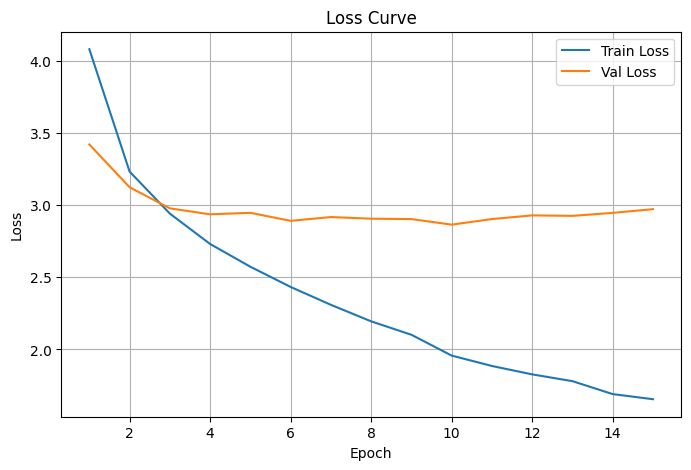

In [57]:
# Plot losses
epochs = range(1, len(train_losses)+1)
plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Curve')
plt.legend(); plt.grid(True); plt.show()

# Visualize some sample predictions

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/3747713853.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend 

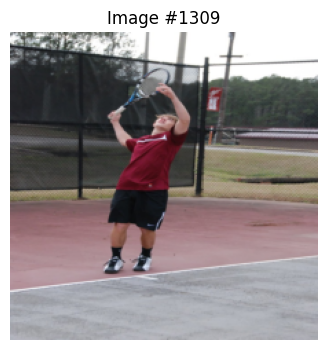

Generated captions:
  1. một vận_động_viên đang thực_hiện cú đánh trái tay mạnh_mẽ trên sân tennis
  2. một vận_động_viên đang thực_hiện cú đánh trái tay mạnh_mẽ trên sân
  3. người vận_động_viên đang thực_hiện cú đánh trái tay mạnh_mẽ trên sân tennis
  4. người chơi đang thực_hiện cú đánh bóng mạnh_mẽ trên sân đất nện
  5. người vận_động_viên đang thực_hiện cú đánh trái tay mạnh_mẽ trên sân

----------------------------------------



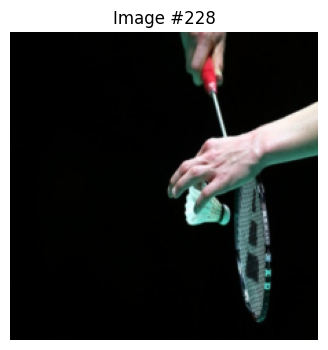

Generated captions:
  1. người vận_động_viên đang thực_hiện cú đánh cầu mạnh_mẽ
  2. người vận_động_viên đang chuẩn_bị thực_hiện cú đánh cầu mạnh_mẽ
  3. người vận_động_viên đang thực_hiện cú đánh cầu mạnh_mẽ trên sân
  4. người vận_động_viên đang thực_hiện một cú đánh cầu mạnh_mẽ
  5. người vận_động_viên đang thực_hiện cú đánh cầu mạnh_mẽ trên sân thi_đấu

----------------------------------------



In [56]:
import torch
import matplotlib.pyplot as plt
import random

# 1. Đặt device chung
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Khởi tạo model, load weights, và đẩy model lên device
vocab_size = len(collate_fn.vocab.get_vocab())
model = ImageCaptioningModel(
    embedding_dim=512,
    max_seq_length=20,
    vocab_size=vocab_size,
    use_sentence_embed=False
)
model.load_state_dict(torch.load("/kaggle/working/best_image_captioning.pt", map_location=device))
model.to(device)
model.eval()

# 3. Chọn 2 ảnh random từ test_dataset
random.seed(42)
indices = random.sample(range(len(test_dataset)), 2)
samples = [test_dataset[i] for i in indices]

# 4. Collate và đẩy batch images lên cùng device
batch = collate_fn(samples)
imgs = batch['images'].to(device)            # <-- sử dụng device thay vì 'cuda' cứng
captions = batch['captions'].to(device)      # nếu có dùng captions trong generate

# 5. Inference: sinh 5 captions mỗi ảnh
generated = model.generate(
    imgs,
    max_length=20,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_beams=10,
    num_return_sequences=5
)

# 6. Decode và hiển thị
all_caps = [collate_fn.vocab.decode(seq.cpu().tolist()) for seq in generated]
mean = torch.tensor([0.485,0.456,0.406], device=device).view(3,1,1)
std  = torch.tensor([0.229,0.224,0.225], device=device).view(3,1,1)

for i, (orig_img, _) in enumerate(samples):
    # de-normalize
    img_t = imgs[i] * std + mean
    img_np = img_t.clamp(0,1).permute(1,2,0).cpu().numpy()

    plt.figure(figsize=(4,4))
    plt.imshow(img_np)
    plt.axis('off')
    plt.title(f"Image #{indices[i]}")
    plt.show()

    print("Generated captions:")
    for j in range(5):
        print(f"  {j+1}. {all_caps[i*5 + j]}")
    print("\n" + "-"*40 + "\n")


In [58]:
!pip install -qq bert-score rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.8 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but yo

In [63]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from transformers import AutoModel, AutoTokenizer
from bert_score.utils import model2layers
import numpy as np

In [64]:
def evaluate_model_ic(model, test_dataset, collate_fn, device='cpu'):
    # 1) Setup model
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model.to(device).eval()
    
    # 2) Prepare scorers
    # BLEU smoothing
    smoothie = SmoothingFunction().method1
    # ROUGE-L
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False)
    # PhoBERT for BERTScore
    phobert_name = "vinai/phobert-base"
    pho_model = AutoModel.from_pretrained(phobert_name)
    pho_tokenizer = AutoTokenizer.from_pretrained(phobert_name)
    # register layer count if missing
    if phobert_name not in model2layers:
        model2layers[phobert_name] = 12
    
    # containers
    bleu4s, rougeLs, bertPs, bertRs, bertF1s = [], [], [], [], []
    
    # 3) Iterate dataset
    for img, raw_caption in tqdm(test_dataset, desc="Evaluating"):
        # a) preprocess image → tensor (1,3,224,224)
        img_tensor = collate_fn.process_images([img]).to(device)
        
        # b) generate (top-1 beam)
        with torch.no_grad():
            gen_ids = model.generate(
                img_tensor,
                max_length=20,
                num_beams=5,
                num_return_sequences=1,
                do_sample=False
            )
        gen_tokens = gen_ids[0].cpu().tolist()
        gen_caption = collate_fn.vocab.decode(gen_tokens)
        
        # c) prepare references
        ref_tokens = raw_caption.split()
        
        
        # d) BLEU-4
        bleu = sentence_bleu(
            [ref_tokens],
            gen_caption.split(),
            weights=(0.25,0.25,0.25,0.25),
            smoothing_function=smoothie
        )
        bleu4s.append(bleu)
        
        # e) ROUGE-L
        rl = rouge.score(raw_caption, gen_caption)['rougeL'].fmeasure
        rougeLs.append(rl)
        
        # f) BERTScore
        P, R, F1 = bert_score(
            [gen_caption],
            [raw_caption],
            model_type=phobert_name,
            lang="vi",
            rescale_with_baseline=True,
            device=device,
            use_fast_tokenizer=True
        )
        bertPs.append(P.item())
        bertRs.append(R.item())
        bertF1s.append(F1.item())
    
    # 4) compute averages
    results = {
        "BLEU-4":  np.mean(bleu4s),
        "ROUGE-L": np.mean(rougeLs),
        "BERT-P":  np.mean(bertPs),
        "BERT-R":  np.mean(bertRs),
        "BERT-F1": np.mean(bertF1s)
    }
    
    # 5) print
    print("\n=== Evaluation Results ===")
    for name, val in results.items():
        print(f"{name:10s}: {val:.4f}")
    
    return results

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ImageCaptioningModel(512, 20, vocab_size, use_sentence_embed=False)
model.load_state_dict(torch.load("best_image_captioning.pt", map_location=device))


In [ ]:

# 1. Load best checkpoint
vocab_size = len(collate_fn.vocab.get_vocab())
model = ImageCaptioningModel(512, 20, vocab_size, use_sentence_embed=False)
ckpt = torch.load("/kaggle/working/best_image_captioning.pt", map_location=device)
model.load_state_dict(ckpt)
model.to(device)

# 2. Run evaluation
results = evaluate_model_ic(model, test_dataset, collate_fn, device=device)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/4190760889.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend y


=== Evaluation Results ===
BLEU-4    : 0.0332
ROUGE-L   : 0.3537
BERT-P    : 0.4775
BERT-R    : 0.4444
BERT-F1   : 0.4598
